## Library installation

In [ ]:
!pip install -q "flwr[simulation]" flwr-datasets

In [ ]:
!pip install transformers

In [ ]:
!pip install torch==1.13.1+cpu torchvision==0.14.1+cpu --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install matplotlib

In [ ]:
!pip install scikit-learn

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn

import tqdm

from datasets import Dataset, DatasetDict
from flwr_datasets.partitioner import IidPartitioner

from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Subset

from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer

## Data preprocessing

In [2]:
label_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2,
}

In [3]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df[["sentence", "gold_label"]].rename(columns={"sentence": "text", "gold_label": "label"})
    df = df[df.label != "mixed"].dropna()
    df["label"] = df["label"].map(label_mapping)

    return df

In [4]:
def tokenize_data(ds: Dataset, tokenizer: PreTrainedTokenizer) -> pd.DataFrame:
    ds = ds.map(
        lambda s, tok: {
            "ids": (encoded := tok(s["text"], truncation=True, padding=True))["input_ids"],
            "attention_mask": encoded["attention_mask"],
        },
        fn_kwargs={"tok": tokenizer},
    )

    return ds

In [5]:
training_data = preprocess_data(pd.read_json("data/dynasent-v1.1-round01-yelp-train.jsonl", lines=True))
validation_data = preprocess_data(pd.read_json("data/dynasent-v1.1-round01-yelp-test.jsonl", lines=True))

In [6]:
joint_data = pd.concat([training_data, validation_data], ignore_index=True)

In [7]:
training_data, validation_data = train_test_split(joint_data, test_size=0.15)

In [8]:
training_ds = Dataset.from_pandas(training_data, preserve_index=False)
validation_ds = Dataset.from_pandas(validation_data, preserve_index=False)

In [9]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [10]:
training_ds = tokenize_data(training_ds, distilbert_tokenizer)
validation_ds = tokenize_data(validation_ds, distilbert_tokenizer)

Map:   0%|          | 0/71474 [00:00<?, ? examples/s]

Map:   0%|          | 0/12614 [00:00<?, ? examples/s]

In [11]:
training_ds = training_ds.with_format(type="torch", columns=["ids", "label", "attention_mask"])
validation_ds = validation_ds.with_format(type="torch", columns=["ids", "label", "attention_mask"])

In [12]:
DatasetDict({"train": training_ds, "test": validation_ds})

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'ids', 'attention_mask'],
        num_rows: 71474
    })
    test: Dataset({
        features: ['text', 'label', 'ids', 'attention_mask'],
        num_rows: 12614
    })
})

In [13]:
def get_data_loader(dataset: Dataset, batch_size: int, pad_index, shuffle=False) -> DataLoader:
    def collate_fn(batch):
        batch_ids = nn.utils.rnn.pad_sequence([i["ids"] for i in batch], padding_value=pad_index, batch_first=True)
        batch_label = torch.stack([i["label"] for i in batch])
        batch_mask = nn.utils.rnn.pad_sequence([i["attention_mask"] for i in batch], padding_value=pad_index, batch_first=True)
        
        return {
            "ids": batch_ids,
            "label": batch_label,
            "attention_mask": batch_mask,
        }
    
    dl = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle
    )
    
    return dl

In [14]:
training_dl = get_data_loader(training_ds, 32, distilbert_tokenizer.pad_token_id, shuffle=True)
validation_dl = get_data_loader(validation_ds, 32, distilbert_tokenizer.pad_token_id)

## Model definition

In [15]:
class Transformer(nn.Module):
    def __init__(self, transformer, num_classes: int, freeze: bool):
        super().__init__()
        
        self.transformer = transformer
        self.fc = nn.Linear(transformer.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(0.3)
        
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    
    def forward(self, ids: torch.Tensor, attention_mask: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        output = self.transformer(ids, attention_mask=attention_mask, output_attentions=True)
        pooled_mean = torch.mean(output.last_hidden_state, dim=1)
        cls_hidden = self.dropout(pooled_mean)
        prediction = self.fc(cls_hidden)

        return prediction, output.attentions

In [16]:
distilbert_tf = AutoModel.from_pretrained("distilbert-base-uncased")

model = Transformer(distilbert_tf, num_classes=3, freeze=False)

## Loading from backup
### Checkpoint loading

In [ ]:
checkpoint = torch.load("model/checkpoint.pth")

In [ ]:
model.load_state_dict(checkpoint["model_state_dict"])

### Trained model loading

In [ ]:
model.load_state_dict(torch.load("model/trained_model.pth", weights_only=True))

## Model configuration

In [17]:
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 66365187


In [18]:
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = criterion.to(device)

print(model)

Transformer(
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_

## Training and evaluation

In [19]:
def get_accuracy(prediction, label):
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return accuracy_score(actual_labels, predicted_classes)

def get_precision(prediction, label):
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return precision_score(actual_labels, predicted_classes, average="macro", zero_division=0)

def train(net: Transformer, data_loader: DataLoader, optimizer: torch.optim.Optimizer) -> tuple[np.float64, np.float64, np.float64]:
    net.train()
    
    batch_losses = []
    batch_accuracies = []
    batch_precisions = []
    
    for batch in tqdm.tqdm(data_loader, desc="Training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        prediction, _ = net(ids, attention_mask)
        
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        precision = get_precision(prediction, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
        batch_accuracies.append(accuracy)
        batch_precisions.append(precision.item())
        
    return np.mean(batch_losses), np.mean(batch_accuracies), np.mean(batch_precisions)

def test(net: Transformer, data_loader: DataLoader) -> tuple[np.float64, np.float64, np.float64]:
    net.eval()
    
    batch_losses = []
    batch_accuracies = []
    batch_precisions = []
    
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="Evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            prediction, _ = net(ids, attention_mask)
            
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            precision = get_precision(prediction, label)
            
            batch_losses.append(loss.item())
            batch_accuracies.append(accuracy)
            batch_precisions.append(precision.item())
            
    return np.mean(batch_losses), np.mean(batch_accuracies), np.mean(batch_precisions)

def run_centralized(
        training_loader: DataLoader,
        validation_loader: DataLoader,
        epochs: int,
        learning_rate: float,
        save_checkpoints: bool,
        first_epoch: int = 0,
        optimizer_state_dict = None,
) -> dict[str, dict[str, list[np.float64]]]:
    train_losses = []
    train_accuracies = []
    train_precisions = []

    test_losses = []
    test_accuracies = []
    test_precisions = []
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    if optimizer_state_dict:
        optimizer.load_state_dict(optimizer_state_dict)

    for epoch in range(first_epoch, epochs):
        print(f"Training epoch #{epoch + 1}:")
        
        train_loss, train_accuracy, train_precision = train(model, training_loader, optimizer)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)

        print(f"{train_loss = }")
        print(f"{train_accuracy = }")
        print(f"{train_precision = }")

        test_loss, test_accuracy, test_precision = test(model, validation_loader)
        
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        test_precisions.append(test_precision)

        print(f"{test_loss = }")
        print(f"{test_accuracy = }")
        print(f"{test_precision = }")
        
        if save_checkpoints:
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train": {"loss": train_losses, "accuracy": train_accuracies, "precision": train_precisions},
                "test": {"loss": test_losses, "accuracy": test_accuracies, "precision": test_precisions},
            }, "model/checkpoint.pth")
            
    return {
        "train": {"loss": train_losses, "accuracy": train_accuracies, "precision": train_precisions},
        "test": {"loss": test_losses, "accuracy": test_accuracies, "precision": test_precisions},
    }

In [20]:
n = 6
lr = 1e-6

In [21]:
metrics = run_centralized(
    training_dl,
    validation_dl,
    epochs=n,
    learning_rate=lr,
    save_checkpoints=True,
    #first_epoch=checkpoint["epoch"],
    #optimizer_state_dict=checkpoint["optimizer_state_dict"],
)

Training epoch #1:


Training...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2234/2234 [58:12<00:00,  1.56s/it]


train_loss = 0.8214894549165758
train_accuracy = 0.6310958171690043
train_precision = 0.5050086205602016


Evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:04<00:00,  2.14it/s]


test_loss = 0.6920864326289937
test_accuracy = 0.7093354430379747
test_precision = 0.6777449074606964
Training epoch #2:


Training...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2234/2234 [58:47<00:00,  1.58s/it]


train_loss = 0.6843433158543885
train_accuracy = 0.7123899582214264
train_precision = 0.6773455268504271


Evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:03<00:00,  2.15it/s]


test_loss = 0.6583427707605725
test_accuracy = 0.7272943037974684
test_precision = 0.697256112893699
Training epoch #3:


Training...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2234/2234 [58:54<00:00,  1.58s/it]


train_loss = 0.6518663878326664
train_accuracy = 0.728468802844922
train_precision = 0.6944723569272178


Evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:04<00:00,  2.14it/s]


test_loss = 0.6429623726048047
test_accuracy = 0.7377373417721519
test_precision = 0.7173538683125744
Training epoch #4:


Training...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2234/2234 [58:45<00:00,  1.58s/it]


train_loss = 0.6300579248898351
train_accuracy = 0.7386880781856162
train_precision = 0.7102370724020166


Evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:03<00:00,  2.15it/s]


test_loss = 0.6327607501156722
test_accuracy = 0.7384493670886076
test_precision = 0.7075202082272127
Training epoch #5:


Training...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2234/2234 [58:45<00:00,  1.58s/it]


train_loss = 0.6120216176113916
train_accuracy = 0.7472831493086641
train_precision = 0.717984657386317


Evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:04<00:00,  2.15it/s]


test_loss = 0.6255583604302587
test_accuracy = 0.7426424050632912
test_precision = 0.7246261285613278
Training epoch #6:


Training...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2234/2234 [58:44<00:00,  1.58s/it]


train_loss = 0.595385405616026
train_accuracy = 0.7556217671341888
train_precision = 0.7285108083825077


Evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:04<00:00,  2.14it/s]


test_loss = 0.6175759482610075
test_accuracy = 0.7455696202531645
test_precision = 0.7219341219675693


In [22]:
torch.cuda.empty_cache()

### Predictions on 10 random samples

In [24]:
reverse_mapping = {v: k for k, v in label_mapping.items()}

random_indices = random.sample(range(0, len(validation_ds)), 10)

texts = [validation_ds['text'][i] for i in random_indices]
labels = [validation_ds['label'][i].item() for i in random_indices]
predictions = []

prediction_sample = get_data_loader(Subset(validation_ds, random_indices), 1, distilbert_tokenizer.pad_token_id)

In [25]:
model.eval()

with torch.no_grad():
    i = 0
    
    for batch in prediction_sample:
        ids = batch["ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        prediction, _ = model(ids, attention_mask)
        predicted_class = prediction.argmax(dim=-1)

        predictions.append(predicted_class.item())

In [26]:
for item in list(zip(texts, [reverse_mapping[l] for l in labels], [reverse_mapping[p] for p in predictions])):
    print(item)

('50 cent wings and $1.50 beers on Wednesday.', 'neutral', 'neutral')
('It was as if I was back in Phnom Penh eating at one of their restaurants off the riverside.', 'positive', 'neutral')
('Ive been there twice shopping for my bf as suprises / now christmas gifts to put away for next month..', 'neutral', 'neutral')
("These guys are money hungry it's as simple as that", 'negative', 'neutral')
("Also ALFONSO'S prices are lower and no extra charge for potatoes or cheese.", 'positive', 'positive')
('Kill!', 'negative', 'neutral')
("You'll probably have to wait to get a seat.", 'negative', 'negative')
('My ride cost $33 to one of the closest hotels on the strip to the airport in the quiet morning hour.', 'neutral', 'neutral')
('Nice stop when on the North Shore!', 'positive', 'positive')
('Make sure you ask for the red and green spices.', 'positive', 'neutral')


### Model saving

In [27]:
torch.save(model.state_dict(), "model/trained_model.pth")

### Evaluation graph

In [28]:
epoch_rng = range(1, n + 1)

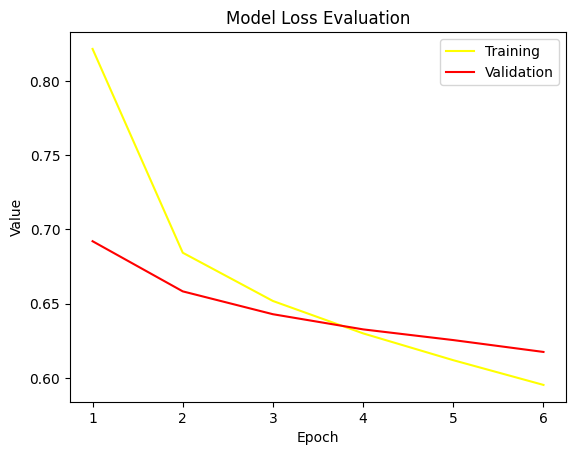

In [29]:
plt.plot(epoch_rng, metrics["train"]["loss"], label="Training", color="yellow")
plt.plot(epoch_rng, metrics["test"]["loss"], label="Validation", color="red")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Loss Evaluation")
plt.legend()
plt.show()

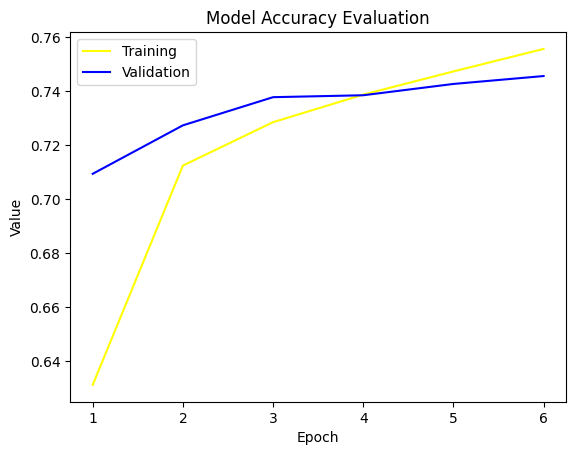

In [30]:
plt.plot(epoch_rng, metrics["train"]["accuracy"], label="Training", color="yellow")
plt.plot(epoch_rng, metrics["test"]["accuracy"], label="Validation", color="blue")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Accuracy Evaluation")
plt.legend()
plt.show()

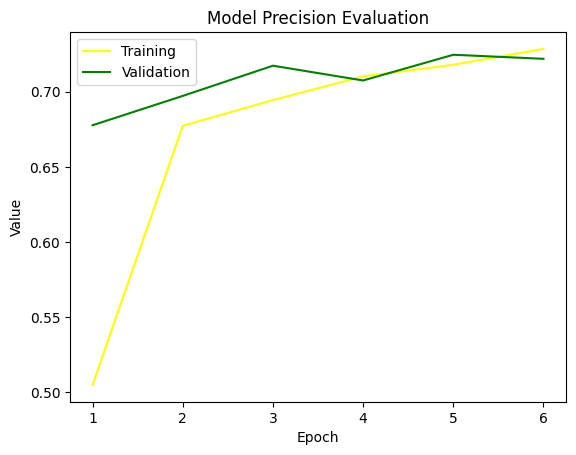

In [31]:
plt.plot(epoch_rng, metrics["train"]["precision"], label="Training", color="yellow")
plt.plot(epoch_rng, metrics["test"]["precision"], label="Validation", color="green")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Precision Evaluation")
plt.legend()
plt.show()